# First Steps

In [48]:
from sklearn.model_selection import train_test_split
import pandas as pd
import nbimporter
from feature_engineering import get_scores
import numpy as np

In [49]:
df = pd.read_csv('/Users/greysonmeyer/Downloads/cleaned_film_data.csv')

In [ ]:
y = df['revenue']
X_train_scoreless, X_test_scoreless, y_train, y_test = train_test_split(df, y)
X_train, X_test = get_scores(X_train_scoreless, X_test_scoreless)
X_train = X_train.drop(columns=['revenue', 'release_date', 'movie_id', 'title', 'director', 'lead_actor', 'second_actor', 'third_actor'])
X_test = X_test.drop(columns=['revenue', 'release_date', 'movie_id', 'title', 'director', 'lead_actor', 'second_actor', 'third_actor'])
print(X_train.columns)

Index(['budget', 'popularity', 'runtime', 'genre_Action', 'genre_Adventure',
       'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family',
       'genre_Fantasy', 'genre_Other', 'genre_Romance',
       'genre_Science Fiction', 'genre_Thriller', 'award_season',
       'summer_blockbuster', 'winter_low_season', 'likely_sequel',
       'num_prev_films_by_director', 'production_company_Columbia Pictures',
       'production_company_Metro-Goldwyn-Mayer (MGM)',
       'production_company_New Line Cinema', 'production_company_Other',
       'production_company_Paramount Pictures',
       'production_company_Relativity Media',
       'production_company_Touchstone Pictures',
       'production_company_Twentieth Century Fox Film Corporation',
       'production_company_Universal Pictures',
       'production_company_Walt Disney Pictures',
       'production_company_Warner Bros.', 'director_avg_revenue',
       'lead_actor_avg_revenue', 'lead_actor_count',
       'second_actor_avg_revenue

# Model 1: Ridge vs Lasso vs Elastic Net

In [51]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = np.logspace(-3, 3, 100)

ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train_scaled, y_train)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000).fit(X_train_scaled, y_train)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, 1], cv=5, max_iter=10000).fit(X_train_scaled, y_train)

/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7787563883343872.0, tolerance: 7043167080538556.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.325181968279757e+16, tolerance: 7043167080538556.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7152656621355008.0, tolerance: 6783216910753820.0
  model = cd_fast.enet_coordinate_descent_gram(
/

Now we evaluate and compare.

In [53]:
models = {
    'Ridge': ridge,
    'Lasso': lasso,
    'ElasticNet': elastic
}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:\n  Best Alpha: {model.alpha_:.4f}")
    if name == 'ElasticNet':
        print(f"  Best l1_ratio: {model.l1_ratio_:.2f}")
    print(f"  RMSE: {rmse:.2f}\n  R²: {r2:.2f}\n")

Ridge:
  Best Alpha: 215.4435
  RMSE: 106413463.04
  R²: 0.62

Lasso:
  Best Alpha: 1000.0000
  RMSE: 106187322.16
  R²: 0.62

ElasticNet:
  Best Alpha: 0.2656
  Best l1_ratio: 0.70
  RMSE: 106387444.38
  R²: 0.62



Let's pick one and check for homoscedasticity.

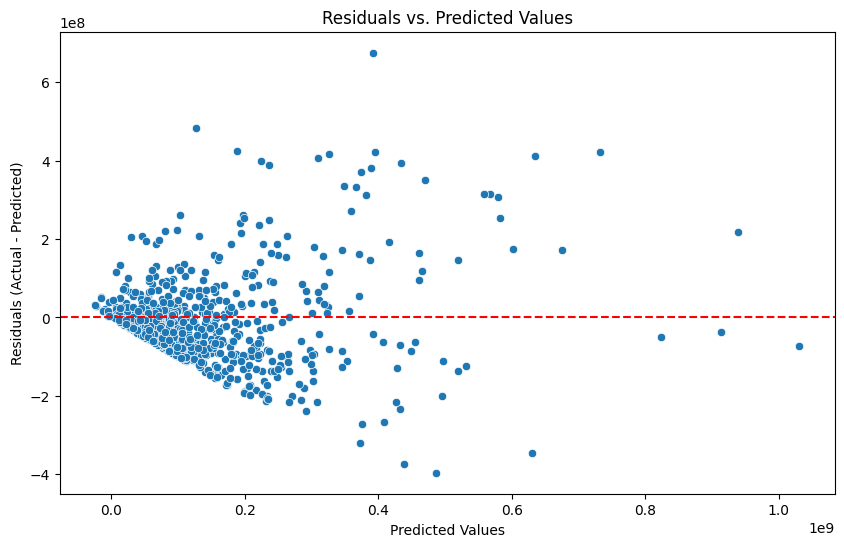

In [54]:
ridge = Ridge(alpha=81.1131)
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')  # Reference line at zero
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.show()

There appears to be heteroscedasticity at play. If we want our predictions to mean anything, we will need to remedy this. I will use box-cox to optimally transform the revenue column and see how it did.

In [55]:
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

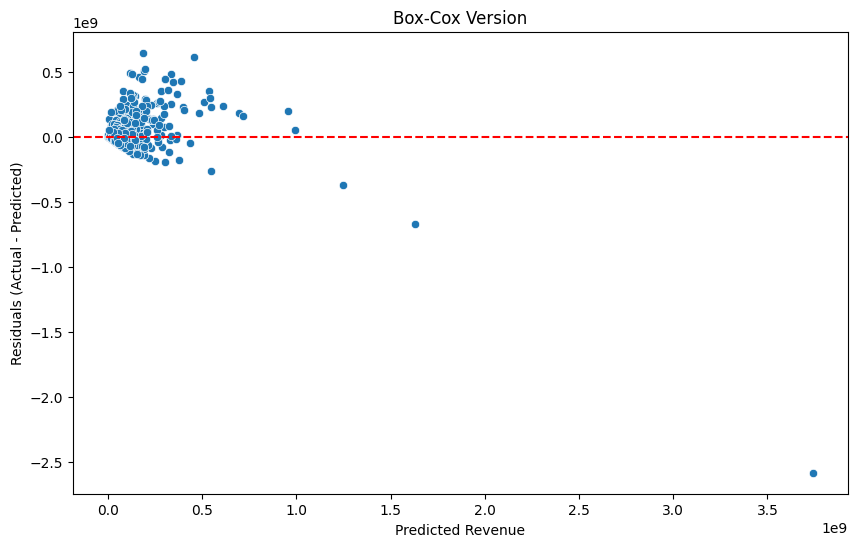

In [56]:
pt = PowerTransformer(method='box-cox', standardize=False)
y_train_box = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_box = pt.transform(y_test.values.reshape(-1, 1)).flatten()
ridge.fit(X_train_scaled, y_train_box)
y_pred = ridge.predict(X_test_scaled)
y_pred_orig = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_orig = pt.inverse_transform(y_test_box.reshape(-1, 1)).flatten()

# Calculate residuals in original space
residuals_orig = y_test_orig - y_pred_orig

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_orig, y=residuals_orig)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Box-Cox Version")
plt.show()

This is better, but let's try Yeo-Johnson and see if that performs better.

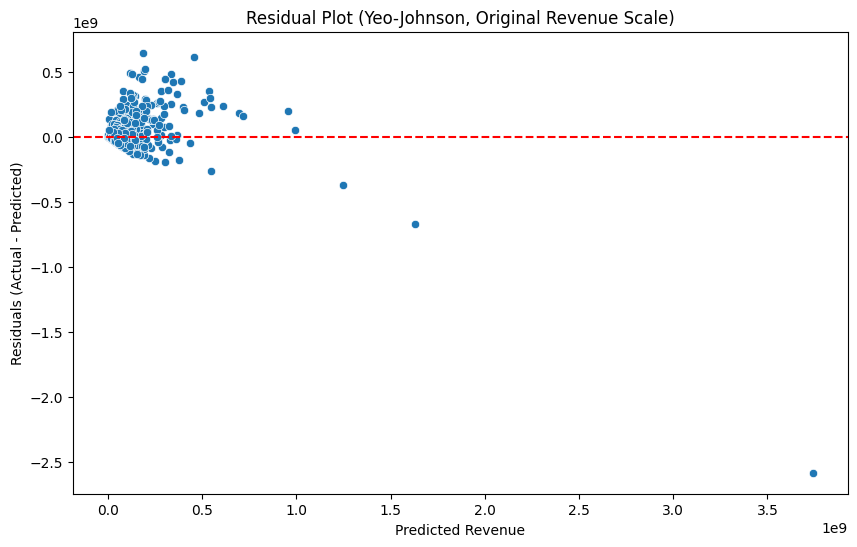

In [57]:
pt2 = PowerTransformer(method='yeo-johnson', standardize=False)
y_train_trans2 = pt2.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_trans2 = pt2.transform(y_test.values.reshape(-1, 1)).flatten()
ridge.fit(X_train_scaled, y_train_trans2)
y_pred2 = ridge.predict(X_test_scaled)
y_pred_orig = pt2.inverse_transform(y_pred2.reshape(-1, 1)).flatten()
y_test_orig = pt2.inverse_transform(y_test_trans2.reshape(-1, 1)).flatten()

# Calculate residuals in original space
residuals_orig = y_test_orig - y_pred_orig

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_orig, y=residuals_orig)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Yeo-Johnson, Original Revenue Scale)")
plt.show()

Well, it looks like heteroscedasticity is present no matter what. That makes these linear models unreliable. Instead I will focus on nonparametric models. I will continue to use the Box-Cox transformed versions of the revenues for the future models to reduce the amount of heteroscedasticity that the nonparametric models will be encountering.

# Random Forests

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ParameterSampler, KFold

We start by initializing a baseline model so that we can get feature_importance scores that will make our data more useful during the hyperparameter tuning later on.

In [59]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train_box)
y_pred = forest.predict(X_test)
y_pred_orig = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
print("RMSE:", mean_squared_error(y_test, y_pred_orig, squared=False))
print("R^2:", r2_score(y_test, y_pred_orig))

RMSE: 133290063.83880444
R^2: 0.4013226995200798


Now we check feature importance scores.

In [60]:
importances = forest.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
# print(feat_imp)

In [61]:
X_train = X_train.drop(columns=['production_company_Walt Disney Pictures', 'production_company_New Line Cinema', 'likely_sequel', 'production_company_Metro-Goldwyn-Mayer (MGM)', 'production_company_Other', 'production_company_Relativity Media', 'genre_Family', 'production_company_Columbia Pictures', 'production_company_Paramount Pictures', 'genre_Fantasy', 'production_company_Touchstone Pictures', 'production_company_Universal Pictures', 'genre_Science Fiction', 'production_company_Twentieth Century Fox Film Corporation', 'genre_Adventure', 'genre_Other', 'genre_Comedy', 'summer_blockbuster', 'genre_Romance', 'genre_Drama', 'production_company_Warner Bros.', 'genre_Crime', 'award_season', 'genre_Action', 'genre_Thriller', 'winter_low_season', 'num_prev_films_by_director', 'lead_actor_count', 'runtime', 'second_actor_count', 'third_actor_count'])
X_test = X_test.drop(columns=['production_company_Walt Disney Pictures', 'production_company_New Line Cinema', 'likely_sequel', 'production_company_Metro-Goldwyn-Mayer (MGM)', 'production_company_Other', 'production_company_Relativity Media', 'genre_Family', 'production_company_Columbia Pictures', 'production_company_Paramount Pictures', 'genre_Fantasy', 'production_company_Touchstone Pictures', 'production_company_Universal Pictures', 'genre_Science Fiction', 'production_company_Twentieth Century Fox Film Corporation', 'genre_Adventure', 'genre_Other', 'genre_Comedy', 'summer_blockbuster', 'genre_Romance', 'genre_Drama', 'production_company_Warner Bros.', 'genre_Crime', 'award_season', 'genre_Action', 'genre_Thriller', 'winter_low_season', 'num_prev_films_by_director', 'lead_actor_count', 'runtime', 'second_actor_count', 'third_actor_count'])

In [62]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_list = list(ParameterSampler(param_grid, n_iter=30, random_state=42))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = float('inf')
best_params = None
for params in param_list:
    fold_rmse = []
    for train_idx, val_idx in kf.split(X_train_scoreless):
        X_tr_temp, X_val_temp = X_train_scoreless.iloc[train_idx], X_train_scoreless.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr, X_val = get_scores(X_tr_temp, X_val_temp)

        pt = PowerTransformer(method='box-cox', standardize=False)
        y_tr_box = pt.fit_transform(y_tr.values.reshape(-1,1)).flatten()

        model = RandomForestRegressor(n_jobs=-1, **params)
        model.fit(X_tr, y_tr_box)

        y_val_pred_box = model.predict(X_val)
        y_val_pred_orig = pt.inverse_transform(y_val_pred_box.reshape(-1,1)).flatten()

        rmse = mean_squared_error(y_val, y_val_pred_orig, squared=False)
        fold_rmse.append(rmse)
    avg_rmse = np.mean(fold_rmse)

    if avg_rmse < best_score:
        best_score = avg_rmse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best CV RMSE (original scale): {best_score:.2f}")

pt_final = PowerTransformer(method='box-cox', standardize=False)
y_train_box_full = pt_final.fit_transform(y_train.values.reshape(-1,1)).flatten()
forest = RandomForestRegressor(n_jobs=-1, **best_params)

KeyError: 'revenue'

# XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

param_list = list(ParameterSampler(param_grid, n_iter=30))

kf = KFold(n_splits=5)

best_score = float('inf')
best_params = None
for params in param_list:
    fold_rmse = []
    for train_idx, val_idx in kf.split(X_train_scoreless):
        X_tr_temp, X_val_temp = X_train_scoreless.iloc[train_idx], X_train_scoreless.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr, X_val = get_scores(X_tr_temp, X_val_temp)

        pt = PowerTransformer(method='box-cox', standardize=False)
        y_tr_box = pt.fit_transform(y_tr.values.reshape(-1,1)).flatten()

        model = XGBRegressor(objective='reg:squarederror', **params)
        model.fit(X_tr, y_tr_box)

        y_val_pred_box = model.predict(X_val)
        y_val_pred_box = y_val_pred_box.astype(np.float64)
        y_val_pred_orig = pt.inverse_transform(y_val_pred_box.reshape(-1,1)).flatten()

        rmse = mean_squared_error(y_val, y_val_pred_orig, squared=False)
        fold_rmse.append(rmse)
    avg_rmse = np.mean(fold_rmse)

    if avg_rmse < best_score:
        best_score = avg_rmse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best CV RMSE (original scale): {best_score:.2f}")

pt_final = PowerTransformer(method='box-cox', standardize=False)
y_train_box_full = pt_final.fit_transform(y_train.values.reshape(-1,1)).flatten()
xgb = XGBRegressor(objective='reg:squarederror', **best_params)

Best params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best CV RMSE (original scale): 76739497.07


Fitting 5 folds for each of 30 candidates, totalling 150 fits.

Ok, that's a little bit of an improvement on the random forest model.

# LightGBM

In [ ]:
from lightgbm import LGBMRegressor

Hyperparameter tuning:

In [ ]:
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500]
}

param_list = list(ParameterSampler(param_grid, n_iter=30))

kf = KFold(n_splits=5)

best_score = float('inf')
best_params = None
for params in param_list:
    fold_rmse = []
    for train_idx, val_idx in kf.split(X_train_scoreless):
        X_tr_temp, X_val_temp = X_train_scoreless.iloc[train_idx], X_train_scoreless.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr, X_val = get_scores(X_tr_temp, X_val_temp)

        pt = PowerTransformer(method='box-cox', standardize=False)
        y_tr_box = pt.fit_transform(y_tr.values.reshape(-1,1)).flatten()

        model = LGBMRegressor(**params, verbose=-1)
        model.fit(X_tr, y_tr_box)

        y_val_pred_box = model.predict(X_val)
        y_val_pred_box = y_val_pred_box.astype(np.float64)
        y_val_pred_orig = pt.inverse_transform(y_val_pred_box.reshape(-1,1)).flatten()

        rmse = mean_squared_error(y_val, y_val_pred_orig, squared=False)
        fold_rmse.append(rmse)
    avg_rmse = np.mean(fold_rmse)

    if avg_rmse < best_score:
        best_score = avg_rmse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best CV RMSE (original scale): {best_score:.2f}")

pt_final = PowerTransformer(method='box-cox', standardize=False)
y_train_box_full = pt_final.fit_transform(y_train.values.reshape(-1,1)).flatten()
lgbm = LGBMRegressor(**best_params, verbose=-1)

/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'num_leaves': 31, 'n_estimators': 500, 'learning_rate': 0.01}
Best CV RMSE (original scale): 76193464.31


# KNearestNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 31)}

param_list = list(ParameterSampler(param_grid, n_iter=30))

kf = KFold(n_splits=5)

best_score = float('inf')
best_params = None
for params in param_list:
    fold_rmse = []
    for train_idx, val_idx in kf.split(X_train_scoreless):
        X_tr_temp, X_val_temp = X_train_scoreless[train_idx], X_train_scoreless[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr, X_val = get_scores(X_tr_temp, X_val_temp)

        pt = PowerTransformer(method='box-cox', standardize=False)
        y_tr_box = pt.fit_transform(y_tr.values.reshape(-1,1)).flatten()

        model = KNeighborsRegressor(**params)
        model.fit(X_tr, y_tr_box)

        y_val_pred_box = model.predict(X_val)
        y_val_pred_orig = pt.inverse_transform(y_val_pred_box.reshape(-1,1)).flatten()

        rmse = mean_squared_error(y_val, y_val_pred_orig, squared=False)
        fold_rmse.append(rmse)
    avg_rmse = np.mean(fold_rmse)

    if avg_rmse < best_score:
        best_score = avg_rmse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best CV RMSE (original scale): {best_score:.2f}")

pt_final = PowerTransformer(method='box-cox', standardize=False)
y_train_box_full = pt_final.fit_transform(y_train.values.reshape(-1,1)).flatten()
knn = KNeighborsRegressor(**best_params)

Best params: {'n_neighbors': 11}
Best CV RMSE (original scale): 82125038.59


# Model Comparison

In [47]:
pt_final = PowerTransformer(method='box-cox', standardize=False)
y_train_box_full = pt_final.fit_transform(y_train.values.reshape(-1,1)).flatten()

models = {"Random Forest": forest, "XGBoost": xgb, "LightGBM": lgbm, "KNN": knn}
for m in models:
    if m == 'KNN':
        curr_model = models[m]
        curr_model.fit(X_train_scaled, y_train_box_full)
        y_pred = curr_model.predict(X_test_scaled)
        y_pred_orig = pt.inverse_transform(y_pred.reshape(-1,1)).flatten()
        print(m, ': RMSE ', mean_squared_error(y_test, y_pred_orig, squared=False), ', R^2: ', r2_score(y_test, y_pred_orig), ', MAE: ', mean_absolute_error(y_test, y_pred_orig))
    else:
        curr_model = models[m]
        curr_model.fit(X_train, y_train_box_full)
        y_pred = curr_model.predict(X_test)
        y_pred_orig = pt.inverse_transform(y_pred.reshape(-1,1)).flatten()
        print(m, ': RMSE ', mean_squared_error(y_test, y_pred_orig, squared=False), ', R^2: ', r2_score(y_test, y_pred_orig), ', MAE: ', mean_absolute_error(y_test, y_pred_orig))

Random Forest : RMSE  162958821.688068 , R^2:  0.346741189110627 , MAE:  83803923.47531559
XGBoost : RMSE  159960804.75737634 , R^2:  0.37055659825890885 , MAE:  80579962.77957922
LightGBM : RMSE  162913353.30839464 , R^2:  0.347105679667861 , MAE:  84045636.1517035
KNN : RMSE  147119280.9301779 , R^2:  0.46756240674541394 , MAE:  80614469.11613175
